# Friendship Goals - HackerEarth Challenge

The task is to build a deep learning model that analyzes an image of a gathering among friends, detects the age group of the gathering, and classifies them into groups of toddlers, teenagers, or adults.\

So the label classes are:

- Toddlers
- Teenagers
- Adults

In [4]:
%matplotlib inline

import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
import pandas as pd
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, applications
from sklearn.model_selection import train_test_split
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import time
from tensorflow.keras import backend as k
import csv

In [8]:
tf.keras.backend.set_image_data_format('channels_last')

In [9]:
categories = ['Toddler', 'Teenagers', 'Adults']
CLASSES = len(categories)

In [10]:
PATH = 'data'
train_path = os.path.join(PATH, 'train')
IMG_SIZE=224

## Processing Data

In the below cell, we will take images one by one and convert them to numpy array. Then we will append their labels in the last index for each array and append both the things to train_data list

In [176]:
train_data = []

def create_training_data():
    for category in categories:
        print(category)
        path = os.path.join(train_path, category) 
        class_num = categories.index(category)         # Label index
        
        images = sorted(os.listdir(os.path.join(train_path, category)))    # List contains names of imaages in each ds
        for img in images:
            img_path = os.path.join(train_path, category, img)
            try:
                img_array = cv2.imread(img_path ,cv2.COLOR_BGR2RGB)  # convert to array
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
                train_data.append([new_array, class_num])  # add this to our training_data
    
            except Exception as e:
                print(e)
                pass
  
        random.shuffle(train_data)


create_training_data()

len(train_data)

Toddler
Teenagers
Adults
OpenCV(4.3.0) ..\modules\imgproc\src\resize.cpp:3929: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'



2803

Seperating the features and labels. We will reshape the features to make it flat

In [179]:
X = []
y = []

for features, label in train_data:
    X.append(features)
    y.append(label)

X = np.array(X)
y = np.array(y)
X.shape

(2803, 224, 224, 3)

Lets take a loot at our images

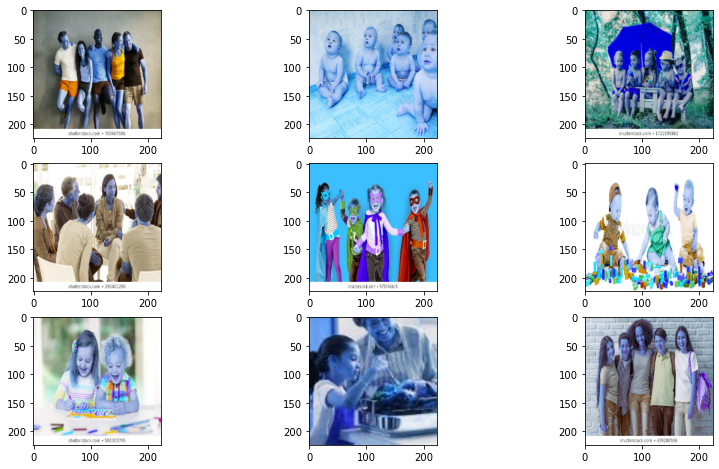

In [180]:
w=60
h=40

fig=plt.figure(figsize=(14, 8))
columns = 3
rows = 3
for i in range(1, columns*rows +1):
    img = X[i]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

Save Features and labels

In [181]:
np.save('features', X, allow_pickle=True, fix_imports=True)
np.save('labels', y, allow_pickle=True, fix_imports=True)

## Trainig


In [182]:
X.shape

(2803, 224, 224, 3)

In [183]:
X = X/255.0      # Normalize
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)


(224, 224, 3)


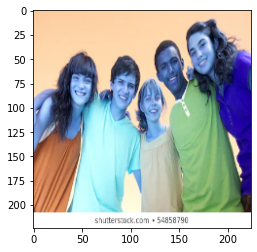

In [184]:
a = X[0]
print(a.shape)
plt.imshow(a)

In [185]:
len(X_train)

2242

In [186]:
ep = 12        # Epochs
bs = 32         # Batch size

In [187]:
NAME = "friendship-day-classifier-{}".format(time.strftime("%d%h-%m-%S"))
tensorboard = TensorBoard(log_dir="""logs\{}""".format(NAME))

def cnn_model(X_train, X_test , y_train, y_test):
    
    base_model = applications.VGG16(include_top=False, input_shape=X_train.shape[1:], weights='imagenet',classes=CLASSES)

    # Freezing VGG16 layers
    for layer in base_model.layers:
        layer.trainable=False
    
    last_layer = 'block5_pool'
    model = Model(base_model.input, base_model.get_layer(last_layer).output)

    model.layers[-1].output.shape
    model = Sequential()

    model.add(base_model)      # Stack vgg16 

    model.add(Conv2D(128,(3,3),activation="relu", input_shape=model.layers[-1].output.shape, padding='same'))
    model.add(MaxPooling2D(pool_size=(3, 3), padding='same'))
    
    model.add(Conv2D(64,(2,2),activation="relu"))
    model.add(MaxPooling2D(2,2))
    
    model.add(Flatten())        # Flatten the output

    model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.5))

    # Output layer
    model.add(Dense(CLASSES, activation="softmax"))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, batch_size=bs, epochs=ep, validation_data = (X_test, y_test), callbacks=[tensorboard])

    # Save model
    model.save(NAME)


In [190]:
cnn_model(X_train, X_test, y_train, y_test)

Train on 2242 samples, validate on 561 samples
Epoch 1/12
2242/2242 [==============================] - 84s 37ms/sample - loss: 1.6221 - accuracy: 0.3840 - val_loss: 1.3981 - val_accuracy: 0.4064
Epoch 2/12
2242/2242 [==============================] - 79s 35ms/sample - loss: 1.2368 - accuracy: 0.5526 - val_loss: 1.2421 - val_accuracy: 0.4528
Epoch 3/12
2242/2242 [==============================] - 80s 35ms/sample - loss: 0.9882 - accuracy: 0.6441 - val_loss: 0.9546 - val_accuracy: 0.6257
Epoch 4/12
2242/2242 [==============================] - 78s 35ms/sample - loss: 0.8237 - accuracy: 0.7150 - val_loss: 0.9455 - val_accuracy: 0.6007
Epoch 5/12
2242/2242 [==============================] - 77s 34ms/sample - loss: 0.6645 - accuracy: 0.7707 - val_loss: 0.8856 - val_accuracy: 0.6560
Epoch 6/12
2242/2242 [==============================] - 83s 37ms/sample - loss: 0.4807 - accuracy: 0.8635 - val_loss: 1.1763 - val_accuracy: 0.5918
Epoch 7/12
2242/2242 [==============================] - 83s 37ms/

## Prediction

In [5]:
test_csv = "./data/test.csv"        # Path to test.csv file
test_images = "./data/test/"        # Path to test images folder

In [6]:
model = tf.keras.models.load_model('friendship-day-classifier-29Jul-07-38')


### Process Images

We will first create and process our training data 

In [11]:
def create_test_data():
    images = []       # List containes path of all the testing images in right seq
    test_data = []    
    df = pd.read_csv(test_csv)
    names_df = df['Filename']
    for img in names_df:
        img_path = os.path.join(test_images, img)
        images.append(img_path)        
    for img_path in images:
        try:
            img_array = cv2.imread(img_path ,cv2.COLOR_BGR2RGB)  # convert to array
            img_array = img_array/255.0
            new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
            test_data.append(new_array.reshape(IMG_SIZE, IMG_SIZE, 3))  # add this to our training_data

        except Exception as e:
            print("Error !!")
            print(e)
            pass
    return test_data

    
test_data = np.array(create_test_data())
print(test_data.shape)

(314, 224, 224, 3)


In [12]:
t = test_data[0]

In [13]:
t.shape

(224, 224, 3)

In [14]:
prediction = model.predict(test_data)

In [15]:
prediction

array([[1.39551699e-01, 6.93837740e-03, 8.53509903e-01],
       [7.84178544e-03, 8.04601371e-01, 1.87556848e-01],
       [9.85394930e-04, 9.94948387e-01, 4.06619254e-03],
       [1.18307937e-02, 9.41958010e-01, 4.62111756e-02],
       [4.27190103e-02, 9.53970492e-01, 3.31044104e-03],
       [2.78764129e-01, 7.15321720e-01, 5.91416238e-03],
       [1.54603695e-04, 5.07007539e-01, 4.92837846e-01],
       [2.82765806e-01, 6.59534633e-01, 5.76996244e-02],
       [3.10909271e-01, 6.71248376e-01, 1.78423226e-02],
       [1.40043814e-03, 9.48055759e-02, 9.03793991e-01],
       [1.47238271e-02, 4.44893092e-01, 5.40383101e-01],
       [1.28742605e-01, 7.25556850e-01, 1.45700634e-01],
       [4.66645695e-03, 9.87830579e-01, 7.50298752e-03],
       [4.03756203e-05, 9.98947203e-01, 1.01241586e-03],
       [8.99447186e-04, 9.77793872e-01, 2.13066861e-02],
       [2.07161019e-03, 8.70540977e-01, 1.27387375e-01],
       [2.28762114e-03, 9.40445244e-01, 5.72671108e-02],
       [6.99930668e-01, 2.94535

In [16]:
results = []
for i in prediction:
    results.append(np.argmax(i))
    
results[:5]

[2, 1, 1, 1, 1]

### Save Results


In [24]:
def save_results(results):
    images = pd.read_csv(test_csv)['Filename']
    with open('results.csv', 'w', newline='') as f:
        w = csv.writer(f)
        w.writerow(["Filename", "Category"])
        for i in range(len(images)):
            res = str(categories[results[i]])
            img = images[i]
            w.writerow([img, res])
            
save_results(results)